# Proyecto 03 - Sistemas de Recomendación

###### Disponible en: https://github.com/polo-edgard/SR

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
# Importar librerías
import gzip
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


def parse(path):   
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [3]:
data_reviews = pd.DataFrame(data_reviews)

In [4]:
# Primeras instancias dataset data_reviews
print("Las cinco primeras instancias son:")
data_reviews.head()

Las cinco primeras instancias son:


,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [5]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

**Games**

In [6]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [7]:
# Primeras instancias dataset data_games
print("Las cinco primeras instancias son:")
data_games.head()

Las cinco primeras instancias son:


,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [8]:
data_games[data_games.id == '35140']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


### -Parte A - Exploración de Datos.

In [9]:
# Número de filas y columnas del dataset data_reviews
print("El dataset tiene {} filas".format(data_reviews.shape[0]))
print("El dataset tiene {} columnas".format(data_reviews.shape[1]))

El dataset tiene 779307 filas
El dataset tiene 12 columnas


In [10]:
# Número de filas y columnas del dataset data_games
print("El dataset tiene {} filas".format(data_games.shape[0]))
print("El dataset tiene {} columnas".format(data_games.shape[1]))

El dataset tiene 32135 filas
El dataset tiene 16 columnas


In [11]:
# Nombre de las columnas
print("los nombres de las columnas de data_reviews son")
print(list(data_reviews.columns.values))

print("los nombres de las columnas de data_games son")
print(list(data_games.columns.values))

los nombres de las columnas de data_reviews son
['username', 'hours', 'products', 'product_id', 'page_order', 'date', 'text', 'early_access', 'page', 'user_id', 'compensation', 'found_funny']
los nombres de las columnas de data_games son
['publisher', 'genres', 'app_name', 'title', 'url', 'release_date', 'tags', 'discount_price', 'reviews_url', 'specs', 'price', 'early_access', 'id', 'developer', 'sentiment', 'metascore']


In [12]:
# Valores faltantes por cada columna en data_reviews
missing_values_count = data_reviews.isnull().sum()
print("los valores faltantes de cada una de las columnas son")
print(missing_values_count[0:12])

los valores faltantes de cada una de las columnas son
username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64


In [13]:
# Valores faltantes por cada columna en data_games
missing_values_count = data_games.isnull().sum()
print("los valores faltantes de cada una de las columnas son")
print(missing_values_count[0:16])

los valores faltantes de cada una de las columnas son
publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64


In [14]:
# Porcentaje de valores faltantes data_reviews
total_cells = np.product(data_reviews.shape)
total_missing = missing_values_count.sum()
print("El porcentaje de valores faltantes en data_reviews sobre el total de los valores es de", round(total_missing / total_cells*100, 2), "%")

El porcentaje de valores faltantes en data_reviews sobre el total de los valores es de 0.96 %


In [15]:
# Porcentaje de valores faltantes data_games
total_cells = np.product(data_games.shape)
total_missing = missing_values_count.sum()
print("El porcentaje de valores faltantes en data_games sobre el total de los valores es de", round(total_missing / total_cells*100, 2), "%")

El porcentaje de valores faltantes en data_games sobre el total de los valores es de 17.41 %


In [16]:
# Duplicados del DataFrame data_reviews
print("El número de registros duplicados son: {}".format(data_reviews.duplicated().sum()))

El número de registros duplicados son: 0


In [17]:
# Lista de publicadores de juegos
print("Hay {} publicadores de juegos".format(len(data_games["publisher"].unique())))
print ("Los cuáles son {}".format(list(data_games["publisher"].unique())))

Hay 8240 publicadores de juegos
Los cuáles son ['Kotoshiro', 'Making Fun, Inc.', 'Poolians.com', '彼岸领域', nan, 'Trickjump Games Ltd', 'Poppermost Productions', 'RewindApp', 'Qucheza', 'Stegalosaurus Game Development', 'Copperpick Studio', 'Ghulam Jewel', 'Apillo', 'Tero Lunkka', 'FrozenPepper', 'Casey Labrack', 'Stainless Games Ltd', 'Valve', 'dev4play', 'BlueLine Games', 'Games by Brundle', 'ETGgames', 'ProjectorGames', 'Unknown Indie Devs', 'Cisamid Inc.', 'Strategy First', 'Blazing Griffin Ltd.', 'Zachary M Thomas', 'Breakout Studio', 'zha7', 'Ultraint', 'Seth Albertus', 'TPM.CO SOFT WORKS', 'Wonderbox Games', 'Mad Unicorn Games', 'Majesco', 'Introversion Software', 'SimBin', 'Unknown Worlds Entertainment', 'CINEMAX, s.r.o.', 'Funcom', 'Capcom', '2K Games', 'Arkane Studios', '2K Games, Feral Interactive (Mac)', 'Square Enix, Feral Interactive (Mac)', 'Telltale Games', 'id Software', 'THQ Nordic', 'SEGA', 'Big Fish Games', 'Rockstar Games', 'Square Enix', 'Electronic Arts', 'D3Publish

In [18]:
# Lista de juegos
print("Hay {} juegos".format(len(data_games["app_name"].unique())))
print ("Los cuáles son {}".format(list(data_games["app_name"].unique())))

Hay 32095 juegos
Los cuáles son ['Lost Summoner Kitty', 'Ironbound', 'Real Pool 3D - Poolians', '弹炸人2222', 'Log Challenge', 'Battle Royale Trainer', 'SNOW - All Access Basic Pass', 'SNOW - All Access Pro Pass', 'SNOW - All Access Legend Pass', 'Race', 'Uncanny Islands', 'Icarus Six Sixty Six', 'Army of Tentacles: (Not) A Cthulhu Dating Sim: Black GOAT of the Woods Edition', 'Beach Rules', 'Planetarium 2 - Zen Odyssey', 'The first thrust of God', 'SNOW - Starter Pack', 'The first thrust of God - All Aircrafts', 'SNOW - Lifetime Pack', 'After Life VR', 'Kitty Hawk', 'The Warrior Of Treasures', 'Mortars VR', 'RC Plane 3 - Canyon Scenario', 'RC Plane 3 - F-53B', 'DinoBlaster', 'Robotpencil Presents: Understanding 3D for Concept', 'Carmageddon Max Pack', 'Half-Life', 'Fallen Mage', "Don't Get Hit In The Face", 'Lost Cities', 'Twisted Enhanced Edition', 'Vaporwave Simulator', 'Tactics Forever', 'Christmas Santa Troubles', 'Kingdom Watcher', 'Underdone - Soundtrack', 'Bitcoin Clicker', "Disci

 ##### ¿Cuáles son los juegos más populares? ¿Y los menos populares?
 
 ###### Consideraciones preliminares

In [19]:
# Preliminarmente tomaremos como más populares los más comentados en data_reviews
top = 10
tabla = data_reviews.product_id.value_counts().iloc[:top]
a = []
for i in tabla.index:
    a.append(list(data_games.app_name[data_games.id == i]))
print("El top {} de juegos más populares son: {}".format(top, a))

El top 10 de juegos más populares son: [['Team Fortress 2'], ['Rust'], ['Borderlands 2'], ['Fallout 4'], ['Grand Theft Auto V'], ['Undertale'], ['Warframe'], ['Portal 2'], ['DayZ'], ['Robocraft']]


In [20]:
# Tomaremos como menos populares los menos comentados en data_reviews y en su estricta posición
# Hay muchos con un comentario
bottom = 10
tabla2 = data_reviews.product_id.value_counts().iloc[-bottom:]
b = []
for i in tabla2.index:
    b.append(list(data_games.app_name[data_games.id == i]))
print("El top {} de juegos menos populares son: {}".format(bottom, b))

El top 10 de juegos menos populares son: [['Inferno Puzzle'], ["Fabulous - Angela's High School Reunion"], ['Unlocked: The World of Games, Revealed'], ['Tail Drift'], ['Chernobyl: Terrorist Attack'], ['Equalizer'], ['Boneless Zombie'], ['Lost Cosmonaut'], ['Zipple World 2: The Sweet Chaos'], ['Grav Blazer']]


In [21]:
# Identificamos los tipos de datos del dataset
data_reviews.dtypes

username         object
hours           float64
products        float64
product_id       object
page_order        int64
date             object
text             object
early_access       bool
page              int64
user_id          object
compensation     object
found_funny     float64
dtype: object

In [22]:
# Convertimos tipo de dato para columna date
data_reviews['date'] = pd.to_datetime(data_reviews['date'])

In [23]:
print(data_reviews.date.min())
print(data_reviews.date.max())

2010-10-15 00:00:00
2018-01-05 00:00:00


In [24]:
data_reviews.dtypes

username                object
hours                  float64
products               float64
product_id              object
page_order               int64
date            datetime64[ns]
text                    object
early_access              bool
page                     int64
user_id                 object
compensation            object
found_funny            float64
dtype: object

In [25]:
# Descartar columnas poco informativas
data_reviews = pd.DataFrame(data_reviews, columns=[
                            'username', 'hours', 'product_id', 'date', 'text'])
data_reviews.dtypes

username              object
hours                float64
product_id            object
date          datetime64[ns]
text                  object
dtype: object

In [26]:
print(data_reviews.shape)
data_reviews.head()

(779307, 5)


,username,hours,product_id,date,text
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...
1,Ariman1,13.2,328100,2017-08-02,Addictive RPG ! Works fine on linux though it ...
2,freakfantom,0.1,725280,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.
3,The_Cpt_FROGGY,7.8,631920,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...
4,the_maker988,8.2,35140,2018-01-02,"This game was way to linear for me, and compar..."


In [27]:
# Valores faltantes por columnas data_reviews 
data_reviews.isna().sum()*100/len(data_reviews)

username      0.000000
hours         0.338378
product_id    0.000000
date          0.000000
text          0.000000
dtype: float64

In [28]:
# # Valores faltantes por columnas data_games 
data_games.isna().sum()*100/len(data_games)

publisher         25.056792
genres            10.216275
app_name           0.006224
title              6.379337
url                0.000000
release_date       6.432239
tags               0.507235
discount_price    99.299829
reviews_url        0.006224
specs              2.084954
price              4.285047
early_access       0.000000
id                 0.006224
developer         10.266065
sentiment         22.349463
metascore         91.669519
dtype: float64

In [29]:
data_games.drop(columns=['title', 'discount_price', 'reviews_url',
                         'early_access', 'developer', 'sentiment', 'metascore'], inplace=True)

In [30]:
data_games.isna().sum()*100/len(data_games)

publisher       25.056792
genres          10.216275
app_name         0.006224
url              0.000000
release_date     6.432239
tags             0.507235
specs            2.084954
price            4.285047
id               0.006224
dtype: float64

In [31]:
# Nombre de videojuegos faltantes
data_games[data_games.app_name.isna()]

,publisher,genres,app_name,url,release_date,tags,specs,price,id
74,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,NaN,19.99,NaN
2580,NaN,"[Action, Indie]",NaN,http://store.steampowered.com/app/317160/_/,2014-08-26,"[Action, Indie]","[Single-player, Game demo]",NaN,317160


In [32]:
# La URL del registro 2580 determina en el sitio que el nombre es "Duet"
data_games.query('app_name=="Duet"')

,publisher,genres,app_name,url,release_date,tags,specs,price,id
4103,Kumobius,"[Action, Indie]",Duet,http://store.steampowered.com/app/292600/Duet/,2015-08-03,"[Indie, Action, Minimalist, Great Soundtrack, ...","[Single-player, Steam Achievements, Full contr...",4.99,292600


In [33]:
data_games.iloc[2580].app_name = 'Duet'

In [34]:
# Eliminar otros valores faltantes en app_name
data_games.dropna(subset=['app_name'], inplace=True)
data_games.isna().sum()

publisher       8051
genres          3282
app_name           0
url                0
release_date    2066
tags             162
specs            669
price           1377
id                 1
dtype: int64

In [35]:
# Juegos con ID faltantes
data_games[data_games.id.isna()]

,publisher,genres,app_name,url,release_date,tags,specs,price,id
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,NaN


In [36]:
'http://store.steampowered.com/app/200260'.split('app/')[1].split('/')[0]

'200260'

In [37]:
games_id_nan = data_games[data_games.id.isna()].index
for idx in games_id_nan:
    url = data_games.loc[idx].url
    id_game = url.split('app/')[1].split('/')[0]
    data_games.loc[idx].id = id_game

In [38]:
data_games[data_games.index==30961]

,publisher,genres,app_name,url,release_date,tags,specs,price,id
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,200260


In [39]:
data_games.isna().sum()

publisher       8051
genres          3282
app_name           0
url                0
release_date    2066
tags             162
specs            669
price           1377
id                 0
dtype: int64

In [40]:
# Número de filas y columnas del dataset data_games
print("El dataset tiene {} filas".format(data_games.shape[0]))
print("El dataset tiene {} columnas".format(data_games.shape[1]))

El dataset tiene 32134 filas
El dataset tiene 9 columnas


In [41]:
# Videojuegos duplicados
data_games[data_games.duplicated(
    subset=['id'], keep=False)].sort_values(by='publisher')

,publisher,genres,app_name,url,release_date,tags,specs,price,id
13894,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",59.99,612880
14573,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",59.99,612880
1068,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260/Batma...,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,200260
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,200260


In [42]:
data_games.drop_duplicates(subset=['id'], ignore_index=True, inplace=True)

In [43]:
data_games.isna().sum()

publisher       8051
genres          3282
app_name           0
url                0
release_date    2066
tags             162
specs            669
price           1377
id                 0
dtype: int64

###### Filtro de categorías

In [44]:
# Videojuegos con género y especificación faltante
isNan_genre_tag = data_games.genres.isna() & data_games.specs.isna()
df_no_games = data_games[isNan_genre_tag]
print(df_no_games.shape)

(383, 9)


In [45]:
df_no_games.sample(frac=.2)

,publisher,genres,app_name,url,release_date,tags,specs,price,id
17138,NaN,NaN,Poco's Udon World,http://store.steampowered.com/app/640510/Pocos...,2017-06-21,"[Anime, Episodic]",NaN,1.99,640510
23735,NaN,NaN,Tower Unite Dedicated Server,http://store.steampowered.com/app/439660/Tower...,2016-03-29,[Free to Play],NaN,NaN,439660
4420,NaN,NaN,The Man From Orlando,http://store.steampowered.com/app/382650/The_M...,2012-09-07,"[Comedy, Movie]",NaN,1.99,382650
19991,NaN,NaN,Arma 3 Community Guide Series,http://store.steampowered.com/app/544940/Arma_...,2013-03-07,"[Tutorial, Episodic, Free to Play]",NaN,NaN,544940
23957,NaN,NaN,In Search of the Most Dangerous Town on the In...,http://store.steampowered.com/app/452220/In_Se...,2016-03-10,[Documentary],NaN,Free,452220
...,...,...,...,...,...,...,...,...,...
20785,NaN,NaN,"Robotpencil Presents: 3D Coat, Hard Surface Ba...",http://store.steampowered.com/app/549450/Robot...,2016-10-31,"[Design & Illustration, Tutorial]",NaN,5.99,549450
6892,NaN,NaN,Robotpencil Presents: Armor Design: Sci-Fi,http://store.steampowered.com/app/507570/Robot...,2016-08-05,"[Design & Illustration, Tutorial]",NaN,4.99,507570
17157,NaN,NaN,Prisma Illya Drei!!,http://store.steampowered.com/app/626380/Prism...,2017-06-21,"[Anime, Episodic]",NaN,1.99,626380
26340,NaN,NaN,In Search of the Most Dangerous Town on the In...,http://store.steampowered.com/app/380890/In_Se...,2015-06-18,"[Hacking, Documentary]",NaN,Free,380890


In [46]:
data_games = data_games[~isNan_genre_tag]

In [47]:
data_games.shape

(31749, 9)

In [48]:
# Columnas genres, tags y specs faltantes con lista vacia
for col in ['genres', 'tags', 'specs']:
    data_games[col].fillna({i: [] for i in data_games.index}, inplace=True)

In [49]:
data_games.isna().sum()

publisher       7668
genres             0
app_name           0
url                0
release_date    2066
tags               0
specs              0
price           1369
id                 0
dtype: int64

In [50]:
# Instalar librerías faltantes
# !pip install plotly
# !pip install missingno
# !pip install wordcloud
# !pip install implicit

In [51]:
import itertools
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from time import strptime
import datetime
import re
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from scipy.ndimage import gaussian_gradient_magnitude
from IPython.display import display, SVG

In [52]:
# Categorias únicas para genres, tags y specs
#Todas las categorías
data_games['categories'] = data_games['genres'] + data_games['tags'] + data_games['specs']

#Obtencion de categorías únicas
data_games['categories'] = [np.unique(cat) for cat in data_games.categories]

#Removiendo caracteres, ej: Single-player singleplayer, Multiplayer, MultiPlayer, Multi-Player
data_games['categories'] = [[re.sub(r'[^\w\s]', '', subcat).lower() for subcat in cat] for cat in data_games.categories]

In [53]:
# Categorías validas
np.unique(list(itertools.chain(*data_games.categories)))

array(['1980s', '1990s', '25d', '2d', '2d fighter', '360 video',
       '3d platformer', '3d vision', '4 player local', '4x', '6dof',
       'abstract', 'accounting', 'action', 'action rpg',
       'actionadventure', 'adventure', 'agriculture', 'aliens',
       'alternate history', 'america', 'animation  modeling',
       'animation amp modeling', 'anime', 'arcade', 'arena shooter',
       'artificial intelligence', 'assassin', 'asynchronous multiplayer',
       'atmospheric', 'audio production', 'base building',
       'based on a novel', 'basketball', 'batman', 'beat em up',
       'benchmark', 'bikes', 'blood', 'board game', 'bowling', 'building',
       'bullet hell', 'bullet time', 'capitalism', 'captions available',
       'card game', 'cartoon', 'cartoony', 'casual',
       'character action game', 'character customization', 'chess',
       'choices matter', 'choose your own adventure', 'cinematic',
       'city builder', 'classbased', 'classic', 'clicker', 'cold war',
       'c

In [54]:
# Las categorías revisadas y validación con las URL's
INVALID_CATEGORIES = ['photo editing', 'game development', 'documentary', 'video production', 'tutorial', 'software',
                      'movie', 'software training', 'soundtrack', 'utilities', 'accounting', 'downloadable content']

In [55]:
def getTuplesPandas(search_list):
    return [game for game in data_games.itertuples()
            if np.isin(search_list, game.categories).sum() > 0]

In [56]:
pd.DataFrame(getTuplesPandas(['downloadable content'])).head(7)

,Index,publisher,genres,app_name,url,release_date,tags,specs,price,id,categories
0,6,NaN,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Basic Pass,http://store.steampowered.com/app/774276/SNOW_...,2018-01-04,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",9.99,774276,"[crossplatform multiplayer, downloadable conte..."
1,7,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Pro Pass,http://store.steampowered.com/app/774277/SNOW_...,2018-01-04,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",18.99,774277,"[crossplatform multiplayer, downloadable conte..."
2,8,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Legend Pass,http://store.steampowered.com/app/774278/SNOW_...,2018-01-04,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",29.99,774278,"[crossplatform multiplayer, downloadable conte..."
3,16,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - Starter Pack,http://store.steampowered.com/app/774271/SNOW_...,2018-01-03,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",14.99,774271,"[crossplatform multiplayer, downloadable conte..."
4,17,Apillo,"[Adventure, Casual, Indie, Simulation, Strategy]",The first thrust of God - All Aircrafts,http://store.steampowered.com/app/773690/The_f...,2018-01-03,"[Strategy, Adventure, Indie, Casual, Simulatio...","[Single-player, Downloadable Content, Steam Ac...",1.99,773690,"[adventure, casual, downloadable content, indi..."
5,18,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - Lifetime Pack,http://store.steampowered.com/app/774279/SNOW_...,2018-01-03,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",59.99,774279,"[crossplatform multiplayer, downloadable conte..."
6,23,FrozenPepper,"[Racing, Simulation, Sports]",RC Plane 3 - Canyon Scenario,http://store.steampowered.com/app/775880/RC_Pl...,2017-12-22,"[Simulation, Racing, Sports]","[Single-player, Downloadable Content, Steam Ac...",2.99,775880,"[downloadable content, partial controller supp..."


In [57]:
data_games.query('id=="244930"')

,publisher,genres,app_name,url,release_date,tags,specs,price,id,categories
1647,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports, Earl...",SNOW,http://store.steampowered.com/app/244930/SNOW/,2013-10-10,"[Early Access, Sports, Free to Play, Multiplay...","[Single-player, Multi-player, Online Multi-Pla...",Free to Play,244930,"[action, adventure, casual, controller, crossp..."


In [58]:
df_no_games = df_no_games.append(getTuplesPandas(INVALID_CATEGORIES))

In [59]:
df_no_games.shape

(14146, 11)

In [60]:
df_no_games.columns

Index(['publisher', 'genres', 'app_name', 'url', 'release_date', 'tags',
       'specs', 'price', 'id', 'Index', 'categories'],
      dtype='object')

In [61]:
df_no_games.drop('Index', axis=1, inplace=True)

In [62]:
print(df_no_games.shape)
df_no_games.head()

(14146, 10)


,publisher,genres,app_name,url,release_date,tags,specs,price,id,categories
26,NaN,NaN,Robotpencil Presents: Understanding 3D for Con...,http://store.steampowered.com/app/777910/Robot...,2018-01-03,"[Design & Illustration, Tutorial]",NaN,4.99,777910,NaN
2476,NaN,NaN,Us and the Game Industry,http://store.steampowered.com/app/360290/Us_an...,2014-07-28,"[Indie, Game Development, Documentary, Gaming]",NaN,4.99,360290,NaN
2690,NaN,NaN,Double Action Dedicated Server,http://store.steampowered.com/app/317800/Doubl...,2014-10-01,[Free to Play],NaN,NaN,317800,NaN
3394,NaN,NaN,From Bedrooms to Billions,http://store.steampowered.com/app/342430/From_...,2015-03-31,"[Game Development, Documentary, Retro, Gaming]",NaN,9.99,342430,NaN
3478,NaN,NaN,Mortal Kombat: Legacy II,http://store.steampowered.com/app/362280/Morta...,2013-09-26,"[Fighting, Action, Episodic, Free to Play]",NaN,Free,362280,NaN


In [63]:
data_games = data_games[~data_games.id.isin(df_no_games.id)]

In [64]:
data_games.shape

(17986, 10)

In [65]:
# Depuramos specs y tags
data_games.drop(['specs', 'tags'], inplace=True, axis=1)

In [66]:
# llenamos faltantes de genres
data_games['genres'] = data_games['genres'].apply(lambda x: np.nan if len(x) == 0 else x)

In [67]:
data_games.isna().sum()

publisher       2097
genres          2018
app_name           0
url                0
release_date    1922
price            920
id                 0
categories         0
dtype: int64

In [68]:
# Procesar precios
category_prices = lambda x: np.unique(np.array([i for i in list(x) if type(i) == str]))

In [69]:
category_prices(data_games.price)

array(['Free', 'Free Demo', 'Free HITMAN™ Holiday Pack', 'Free Mod',
       'Free To Play', 'Free to Play', 'Play WARMACHINE: Tactics Demo',
       'Play for Free!', 'Play the Demo', 'Third-party'], dtype='<U29')

In [70]:
# precios dataset de utilidades
category_prices(df_no_games.price)

array(['Free', 'Free Movie', 'Free To Play', 'Free to Play',
       'Free to Try', 'Free to Use', 'Install Now', 'Install Theme',
       'Play Now', 'Starting at $449.00', 'Starting at $499.00',
       'Third-party'], dtype='<U19')

In [71]:
def transform_prices(df):
    df['category_price'] = df.price.apply(
        lambda p: 'paid' if (type(p) == float or p.startswith('Starting')) else 'free')
    df.drop('price', axis=1, inplace=True)

In [72]:
transform_prices(data_games)
data_games.head()

,publisher,genres,app_name,url,release_date,id,categories,category_price
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,761140,"[action, casual, indie, simulation, singleplay...",paid
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,643980,"[2d, board game, card game, character customiz...",free
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,670290,"[casual, free to play, inapp purchases, indie,...",free
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,767400,"[action, adventure, casual, singleplayer]",paid
4,NaN,NaN,Log Challenge,http://store.steampowered.com/app/773570/Log_C...,NaN,773570,"[action, casual, full controller support, htc ...",paid


In [73]:
transform_prices(df_no_games)
df_no_games.head()

,publisher,genres,app_name,url,release_date,tags,specs,id,categories,category_price
26,NaN,NaN,Robotpencil Presents: Understanding 3D for Con...,http://store.steampowered.com/app/777910/Robot...,2018-01-03,"[Design & Illustration, Tutorial]",NaN,777910,NaN,paid
2476,NaN,NaN,Us and the Game Industry,http://store.steampowered.com/app/360290/Us_an...,2014-07-28,"[Indie, Game Development, Documentary, Gaming]",NaN,360290,NaN,paid
2690,NaN,NaN,Double Action Dedicated Server,http://store.steampowered.com/app/317800/Doubl...,2014-10-01,[Free to Play],NaN,317800,NaN,paid
3394,NaN,NaN,From Bedrooms to Billions,http://store.steampowered.com/app/342430/From_...,2015-03-31,"[Game Development, Documentary, Retro, Gaming]",NaN,342430,NaN,paid
3478,NaN,NaN,Mortal Kombat: Legacy II,http://store.steampowered.com/app/362280/Morta...,2013-09-26,"[Fighting, Action, Episodic, Free to Play]",NaN,362280,NaN,free


In [74]:
# Procesar fecha de lanzamiento
data_games.release_date.value_counts()

2017-10-31    48
2017-12-01    44
2017-09-01    44
2017-09-15    40
2017-12-15    40
              ..
2018-02-08     1
2010-03-08     1
2009-01-28     1
2003-12-31     1
2011-04-17     1
Name: release_date, Length: 3220, dtype: int64

In [75]:
# Fechas validas para valores categóricos
def isDateValid(x): 
    try:
        return datetime.datetime.strptime(x, '%Y-%m-%d')        
    except:
        return False

In [76]:
invalid_date_games = data_games.query('release_date.notna()', engine='python')
invalid_date_games = pd.DataFrame([i for i in invalid_date_games.itertuples() 
                                   if not isDateValid(i.release_date)])
invalid_date_games.release_date

0            Soon..
1              2017
2         Beta测试已开启
3          Jun 2009
4          Oct 2010
           ...     
247      15.01.2018
248        Q1, 2018
249     Coming Soon
250            2016
251    January 2018
Name: release_date, Length: 252, dtype: object

In [77]:
# Conversión de fechas
def get_month(month):
    if len(month) > 3:
        return strptime(month, '%B').tm_mon
    else:
        return strptime(month, '%b').tm_mon

In [78]:
print('Noviembre:', get_month('Nov'))
print('Noviembre:', get_month('November'))
print('Abril:', get_month('Apr'))
print('Abril:', get_month('April'))

Noviembre: 11
Noviembre: 11
Abril: 4
Abril: 4


In [79]:
# Temporadas y meses de inicio para el país USA
SEASONS = {'Winter': 12, 'Summer': 7, 'Fall': 10, 'Spring': 4}

In [80]:
# Transformación de fechas
def get_date(date_sring):
    try:
        sep = date_sring.split()
        # Primero verifica si es una temporada
        if sep[0] in SEASONS.keys():
            return datetime.datetime(year=int(sep[1]), month=SEASONS.get(sep[0]), day=1).date()

        # Sino, utiliza la función anterior para obtener el número del mes a partir del nombre.
        return datetime.datetime(year=int(sep[1]), month=get_month(sep[0]), day=1).date()
    except:
        # Retorna valor faltante si no se cumplen los dos casos
        return np.nan

In [81]:
example_date = 'Nov 2020'
print('Noviembre', get_date(example_date))

example_date = 'November 2020'
print('Noviembre', get_date(example_date))

example_date = 'Summer 2020'
print('Verano', get_date(example_date))

example_date = 'Winter 2020'
print('Winter', get_date(example_date))

Noviembre 2020-11-01
Noviembre 2020-11-01
Verano 2020-07-01
Winter 2020-12-01


In [82]:
# Transformar fechas categóricas
invalid_date_games.release_date = invalid_date_games.release_date.apply(lambda x: f'{get_date(x)}')
invalid_date_games.release_date

0             nan
1             nan
2             nan
3      2009-06-01
4      2010-10-01
          ...    
247           nan
248           nan
249           nan
250           nan
251    2018-01-01
Name: release_date, Length: 252, dtype: object

In [83]:
# Aplicar cambios
invalid_idx = invalid_date_games.Index.values
data_games.loc[invalid_idx,
               'release_date'] = invalid_date_games.release_date.values

In [84]:
data_games.loc[invalid_idx].head()

,publisher,genres,app_name,url,release_date,id,categories,category_price
10,Qucheza,"[Action, Indie, Simulation, Early Access]",Uncanny Islands,http://store.steampowered.com/app/768570/Uncan...,nan,768570,"[action, early access, indie, simulation, sing...",paid
43,Breakout Studio,"[Indie, Massively Multiplayer, RPG, Early Access]",Life of Rome,http://store.steampowered.com/app/381620/Life_...,nan,381620,"[character customization, crafting, early acce...",paid
44,zha7,"[Adventure, Free to Play, RPG, Early Access]",Idle Adventure,http://store.steampowered.com/app/714020/Idle_...,nan,714020,"[adventure, early access, free to play, mmo, r...",paid
249,Erik Svedäng,"[Adventure, Indie]",Blueberry Garden,http://store.steampowered.com/app/29160/Bluebe...,2009-06-01,29160,"[adventure, indie, puzzle, short, singleplayer]",paid
505,Paradox Interactive,"[RPG, Strategy]",Age of Wonders II: The Wizard's Throne,http://store.steampowered.com/app/61510/Age_of...,2010-10-01,61510,"[4x, classic, fantasy, multiplayer, rpg, singl...",paid


In [85]:
del invalid_date_games

In [86]:
data_games.shape

(17986, 8)

In [87]:
# Valores finales resultantes
data_games.isna().sum()

publisher         2097
genres            2018
app_name             0
url                  0
release_date      1922
id                   0
categories           0
category_price       0
dtype: int64

##### Preprocesamiento de data_reviews

In [88]:
# Reviews duplicados
duplicated = data_reviews[data_reviews.duplicated()]
duplicated.shape

(8692, 5)

In [89]:
data_reviews.shape

(779307, 5)

In [90]:
duplicated.head()

,username,hours,product_id,date,text
1420,Zorklis,2.7,308040,2014-08-06,At first I thought this will be boring and rep...
1565,Galaxyann,7.4,427730,2017-10-18,A really nice and hilarious 2 player game as l...
1781,Hiki,0.9,427730,2017-09-30,The concept of the game is fairly straight-for...
2046,Spicy Michael,9.8,214560,2017-06-29,"Just beat this game. Wow, this was a game I di..."
2769,MadRubicante,25.5,214560,2017-04-14,Very good infiltration game with a great story...


In [91]:
# Seleccionamos un usuario para validar duplicados
data_reviews[data_reviews.username == 'Zorklis']

,username,hours,product_id,date,text
1407,Zorklis,2.7,308040,2014-08-06,At first I thought this will be boring and rep...
1420,Zorklis,2.7,308040,2014-08-06,At first I thought this will be boring and rep...


In [92]:
# Eliminamos duplicados
data_reviews.drop_duplicates(inplace=True, ignore_index=True)

In [93]:
data_reviews.shape

(770615, 5)

In [94]:
data_reviews.isna().sum()

username         0
hours         2634
product_id       0
date             0
text             0
dtype: int64

In [95]:
# Registros duplicados en data_reviews  (Username y product_id)
repeated_reviews = data_reviews[data_reviews.duplicated(
    subset=['username', 'product_id'], keep=False)].sort_values(by='username')

In [96]:
print('Comentarios del mismo usuario al mismo videojuego:', repeated_reviews.shape[0])

Comentarios del mismo usuario al mismo videojuego: 3140


In [97]:
repeated_reviews.head()

,username,hours,product_id,date,text
615751,( ͡° ͜ʖ ͡°),65.5,8930,2016-11-28,10 warwars of 10
384072,( ͡° ͜ʖ ͡°),553.9,440,2016-02-11,Its good until you watch a stream and realise ...
217633,( ͡° ͜ʖ ͡°),23.9,304050,2016-03-05,"Good if you wana grind for 9 hours straight, t..."
652153,( ͡° ͜ʖ ͡°),71.4,8930,2015-12-13,The only way for you to think this is a bad ga...
218591,( ͡° ͜ʖ ͡°),10.7,304050,2016-02-19,Thank's for Games !!


In [98]:
# Ultimos comentarios
unrepeated_reviews = data_reviews.sort_values(
    by='date', ascending=False).drop_duplicates(subset=['username', 'product_id'])

In [99]:
unrepeated_reviews.query('username=="( ͡° ͜ʖ ͡°)" & product_id=="8930"')

,username,hours,product_id,date,text
607845,( ͡° ͜ʖ ͡°),423.3,8930,2017-03-19,This game is definitely for different types of...


In [100]:
data_reviews = unrepeated_reviews.copy()

#Liberando espacio en memoria
del repeated_reviews
del unrepeated_reviews

In [101]:
data_reviews.isna().sum()

username         0
hours         2632
product_id       0
date             0
text             0
dtype: int64

In [102]:
data_reviews.shape

(768903, 5)

In [103]:
# Faltantes en 'hours'
# Promedio de horas por usuario
data_reviews.hours.fillna(data_reviews.groupby('username').hours.transform('mean'), inplace=True)

In [104]:
data_reviews.isna().sum()

username         0
hours         1319
product_id       0
date             0
text             0
dtype: int64

In [105]:
# Horas no calculadas por promedio de horas del usuario
data_reviews[data_reviews.hours.isna()]

,username,hours,product_id,date,text
76558,Viraal,NaN,353370,2018-01-05,"bought controller, fell down from couch on fir..."
581510,MouseyBit,NaN,353380,2018-01-04,Glorified HDMI cable with a wireless card tape...
581523,Skin Vision,NaN,353380,2018-01-04,"Pretty easy to set up and use, but I should do..."
76565,Ninja dos Bunnyhop,NaN,353370,2018-01-04,The lack of a seccond analog stick is a proble...
581556,Volterslam,NaN,353380,2018-01-02,"This worked great, I can even use my old ps3 c..."
...,...,...,...,...,...
12784,Slashgate,NaN,12810,2010-11-26,Overlord is awesome and funny at the same time!
110652,HeyOldMate,NaN,6910,2010-11-24,"The graphics are as old as the Sistine Chapel,..."
244101,func_door,NaN,15100,2010-11-22,probably the worst game I am ashamed to have l...
738977,Vandalazino,NaN,12140,2010-11-20,Hardboiled noir action. One of the greatest PC...


In [106]:
# Horas no calculadas por promedio de horas del juego
data_reviews.hours.fillna(data_reviews.groupby('product_id').hours.transform('mean'), inplace=True)

In [107]:
data_reviews.isna().sum()

username       0
hours         15
product_id     0
date           0
text           0
dtype: int64

In [108]:
data_reviews[data_reviews.hours.isna()]

,username,hours,product_id,date,text
611227,yannick034,NaN,666200,2017-12-31,How do we use it
30402,seed1yet,NaN,550210,2017-12-18,"Why MP3? Why 192kbps? Come on, It's 2017.\nBea..."
269586,LR53,NaN,546360,2017-01-07,I tried the free version of Driver Booster 4 a...
78490,Gainstrive,NaN,465600,2016-10-31,Would be nice if they included instructions on...
471842,Neolexian,NaN,234180,2016-08-06,Really fun. Much more fast-paced than the defa...
68938,Munkie,NaN,391380,2016-07-09,I gave this game a shot but I quickly closed i...
546977,4chtung Becc,NaN,453920,2016-05-01,I had to rent this just to write a review abou...
348945,Kombowz,NaN,407460,2016-04-22,A fantastic addition for a fantastic screen re...
280576,AceHangman,NaN,439900,2016-03-31,Waste Walkers: Deliverance is an addition to t...
127343,SangeroN,NaN,401990,2015-10-22,"Asome tutorial,good price. ^__^\nthank you ver..."


In [109]:
data_reviews.hours.fillna(data_reviews.hours.mean(), inplace=True)

In [110]:
data_reviews.isna().sum()

username      0
hours         0
product_id    0
date          0
text          0
dtype: int64

In [111]:
data_reviews.shape

(768903, 5)

In [112]:
# Filtrando reviews de videojuegos
data_reviews_game = data_reviews.query('product_id not in @df_no_games.id')

# Filtrando reviews de utilidades (Para exportar)
data_reviews_utilites = data_reviews.query('product_id not in @data_games.id')

In [113]:
# Dataset para exportar
data_reviews = data_reviews_game.copy()

del data_reviews_game

In [114]:
print('Reviews games:', data_reviews.shape,
      '- Reviews Utilites:', data_reviews_utilites.shape)

Reviews games: (759235, 5) - Reviews Utilites: (9668, 5)


In [115]:
# Exportando Datasets
directory = 'data_processed_games'
data_reviews.to_csv(f'{directory}/data_reviews_games.csv', index=False)
data_games.to_csv(f'{directory}/data_games.csv', index=False)

In [116]:
directory = 'data_processed_utilities'
data_reviews_utilites.to_csv(f'{directory}/data_reviews_utilites.csv', index=False)
df_no_games.to_csv(f'{directory}/data_utilities.csv', index=False)

In [117]:
# Ajustes al leer datasets
directory = 'data_processed_games'
data_reviews = pd.read_csv(
    f'{directory}/data_reviews_games.csv', converters={'username': str, 'text': str})
data_reviews.date = pd.to_datetime(data_reviews.date)

In [118]:
def toList(x):
    return x[1:-1].replace("'", '').split(', ') if (x is not np.nan) else nan

In [119]:
data_games = pd.read_csv(f'{directory}/data_games.csv',
                         converters={
                             'genres': lambda x: toList(x),
                             'tags': lambda x: toList(x),
                             'specs': lambda x: toList(x),
                             'categories': lambda x: toList(x)
                         })
data_games.release_date = pd.to_datetime(data_games.release_date)

In [120]:
data_reviews.dtypes

username              object
hours                float64
product_id             int64
date          datetime64[ns]
text                  object
dtype: object

In [121]:
data_games.dtypes

publisher                 object
genres                    object
app_name                  object
url                       object
release_date      datetime64[ns]
id                         int64
categories                object
category_price            object
dtype: object

In [122]:
data_games.head()

,publisher,genres,app_name,url,release_date,id,categories,category_price
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,761140,"[action, casual, indie, simulation, singleplay...",paid
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,643980,"[2d, board game, card game, character customiz...",free
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,670290,"[casual, free to play, inapp purchases, indie,...",free
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,767400,"[action, adventure, casual, singleplayer]",paid
4,NaN,[],Log Challenge,http://store.steampowered.com/app/773570/Log_C...,NaT,773570,"[action, casual, full controller support, htc ...",paid


In [123]:
data_reviews.head()

,username,hours,product_id,date,text
0,backsea,30.0,218230,2018-01-05,this game is good dont get me wrong i would li...
1,RaZman,2.2,501300,2018-01-05,Beautifully narrated story about a peculiar fa...
2,Mike Dieu,1.5,367580,2018-01-05,"70 min to finish it, zen ambiance but still ch..."
3,Sqeep The Screamin Frog,13.2,359550,2018-01-05,One of the best tactic games of all time . Tak...
4,lulatic13,6.7,327690,2018-01-05,"a very fun game, with nice character designs a..."


In [124]:
data_reviews.isna().sum()

username      0
hours         0
product_id    0
date          0
text          0
dtype: int64

##### Validación con las consideraciones preliminares

In [125]:
# Usuarios únicos
print(f'{len(data_reviews.username.value_counts())} usuarios únicos')

534925 usuarios únicos


#### Top 10 videojuegos más populares

In [126]:
# Top 10 juegos más populares
amount_by_productId = data_reviews.groupby('product_id').product_id.count().reset_index(name='amount')

In [127]:
reviews_games_amount = pd.merge(amount_by_productId, data_games, left_on='product_id',
                               right_on='id').sort_values(by='amount', ascending=False)
top10 = reviews_games_amount.head(10)

In [128]:
# Valores para mostrar en la leyenda de cada barra
HOVER_DATA_COLUMNS = ['publisher', 'release_date', 'genres', 'category_price']

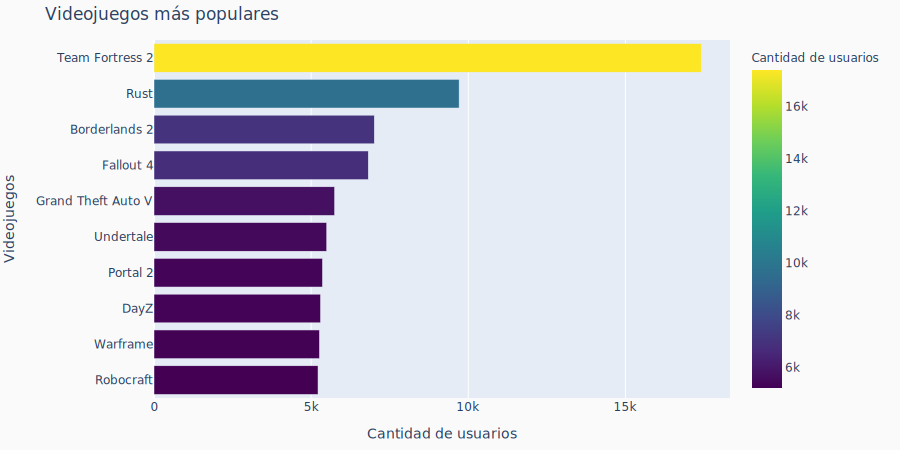

In [129]:
fig = px.bar(top10.sort_values(by='amount'), y='app_name', x='amount', color='amount', title='Videojuegos más populares',
             color_continuous_scale='viridis',
             labels={'app_name': 'Videojuegos',
                     "amount": 'Cantidad de usuarios'},
             hover_data=HOVER_DATA_COLUMNS,
             width=900,
             height=450
             )
fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(l=20, r=20, t=40, b=50)
                  )
display(SVG(fig.to_image(format='svg')))

#### El resultado que nos muestra ahora es muy aproximado a la consideración preliminar

In [130]:
del top10

#### Videojuegos con registro de más tiempo de juego

In [131]:
hours_by_productId = data_reviews.groupby('product_id', as_index=False).hours.sum()

reviews_games_hours = pd.merge(hours_by_productId, data_games, left_on='product_id',
                               right_on='id').sort_values(by='hours', ascending=False)

hours10 = reviews_games_hours.head(10).sort_values(by='hours')

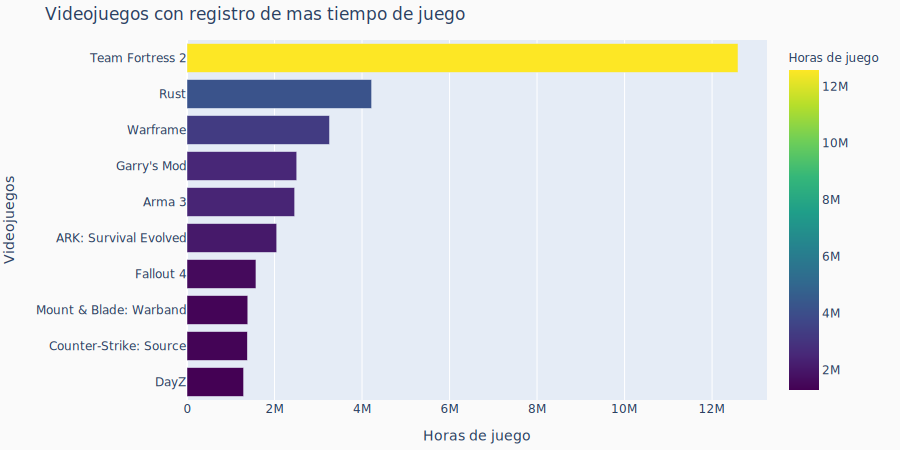

In [132]:
fig = px.bar(data_frame=hours10, y='app_name', x='hours', color='hours', title='Videojuegos con registro de mas tiempo de juego',
             color_continuous_scale='viridis',
             labels={'app_name': 'Videojuegos', "hours": 'Horas de juego'},
             hover_data=HOVER_DATA_COLUMNS,
             width=900,
             height=450
             )

fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(l=20, r=20, t=40, b=10)
                  )
display(SVG(fig.to_image(format='svg')))

In [133]:
#Liberando memoria
del hours_by_productId, reviews_games_hours, hours10

##### Género más popular

In [134]:
all_genres = list(itertools.chain(*data_games.genres))
value, count = np.unique(all_genres, return_counts=True)
order = np.argsort(count)

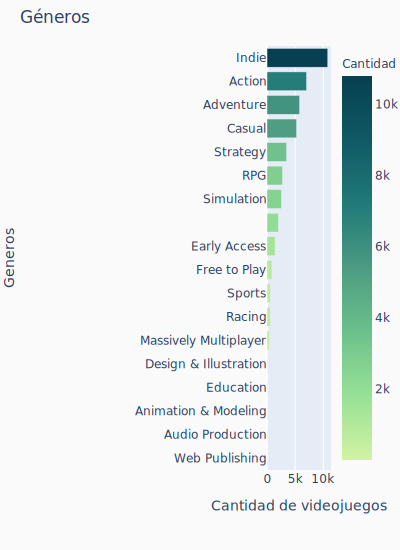

In [135]:
fig = px.bar(x=count[order], y=value[order], color=count[order],
             color_continuous_scale='emrld',
             title='Géneros',
             labels={
                 'x': 'Cantidad de videojuegos',
                 'y': 'Generos', 'color': 'Cantidad'},
             width=400,
             height=550,
             # log_x=True,
             )
fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(l=20, r=20, t=2)
                  )
display(SVG(fig.to_image(format='svg')))

#### Videojuegos de pago mas jugados

In [136]:
df_items = data_games.query('category_price=="paid"')
merge_paid_games = pd.merge(amount_by_productId, df_items, left_on='product_id',
                            right_on='id').sort_values(by='amount', ascending=False).head(10)

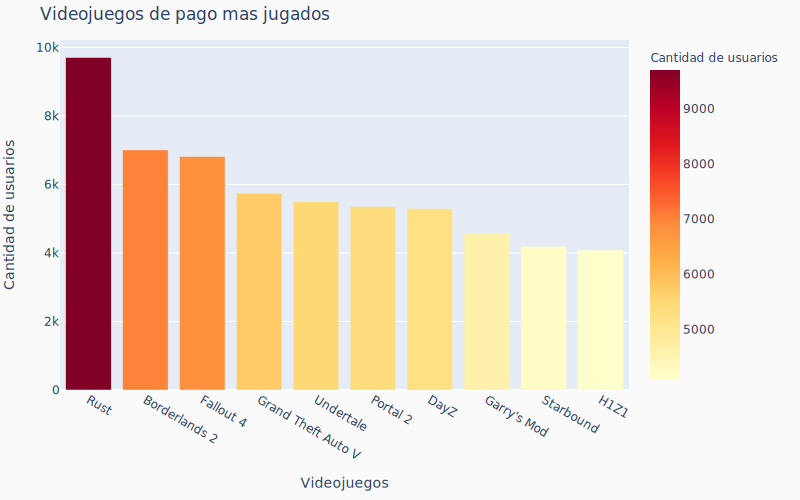

In [137]:
fig = px.bar(data_frame=merge_paid_games, x='app_name', y='amount', title='Videojuegos de pago mas jugados',
             labels={'app_name': 'Videojuegos',
                     'amount': 'Cantidad de usuarios'},
             hover_data=HOVER_DATA_COLUMNS,
             color=merge_paid_games.amount, color_continuous_scale='ylorrd',
             width=800,
             height=500
             )

fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(l=30, r=20, t=40, b=30)
                  )
display(SVG(fig.to_image(format='svg')))

In [138]:
del merge_paid_games

#### Videojuegos gratis mas jugados

In [139]:
df_items = data_games.query('category_price=="free"')
merge_free_games = pd.merge(amount_by_productId, df_items, left_on='product_id',
                            right_on='id').sort_values(by='amount', ascending=False).head(10)

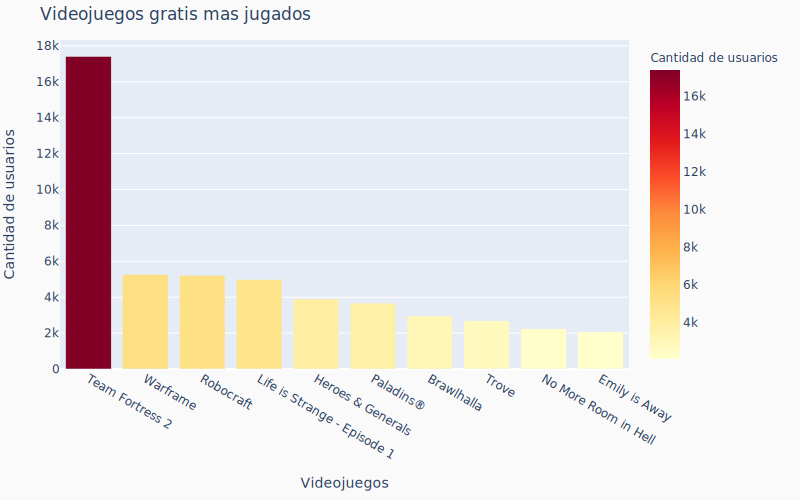

In [140]:
fig = px.bar(data_frame=merge_free_games, x='app_name', y='amount', title='Videojuegos gratis mas jugados',
             labels={'app_name': 'Videojuegos',
                     'amount': 'Cantidad de usuarios', 'color': 'Cantidad'},
             hover_data=HOVER_DATA_COLUMNS,
             color=merge_free_games.amount, color_continuous_scale='ylorrd',
             width=800,
             height=500)

fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(l=20, r=20, t=40, b=30)
                  )
display(SVG(fig.to_image(format='svg')))

In [141]:
del merge_free_games

#### Porcentaje de usuarios por precio de videojuego

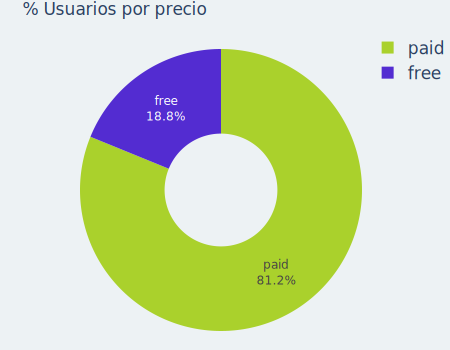

In [142]:
fig = px.pie(reviews_games_amount,
             names='category_price',
             values='amount',
             title='% Usuarios por precio',
             width=450,
             height=350,
             hole=0.4,
             color_discrete_sequence=('#AAD12C', '#532CD1'),
             labels={'category_price': 'Tipo Precio', 'amount': 'Cantidad'}
             )

fig.update_layout(
    margin=dict(t=30, b=0),
    legend=dict(font=dict(size=17)),
    paper_bgcolor='#edf2f4'
)
fig.update_traces(textposition='inside', textinfo='percent+label')
display(SVG(fig.to_image(format='svg')))

### Parte B - Modelo de Machine Learning

##### Se tendrá en cuenta la premisa de que los Sistemas de Recomendación intentan personalizar al máximo lo que se le ofrecerá a cada usuario, en el caso particular de estos datasets la recomendación se basará en que tan popular es un videojuego

#### Usuarios nuevos

In [143]:
def plot_table(df):
    COLUMNS_FOR_USER = ['app_name', 'url', 'category_price']
    fig = go.Figure(go.Table(
        header=dict(values=['Videojuego', 'Sitio web', 'Tipo de precio'],
                    fill_color='#84C374',
                    font=dict(size=13)),
        cells=dict(values=np.vstack(df[COLUMNS_FOR_USER].values).T,
                   fill_color='#B374C3',
                   line_color='black',
                   line_width=.4,
                   font=dict(color='#f1faee'),
                   height=30),
        columnwidth=[1.5, 4, 1]))

    fig.update_layout(width=1000, height=370, margin=dict(t=10, b=0, l=0))
    return display(SVG(fig.to_image('svg')))

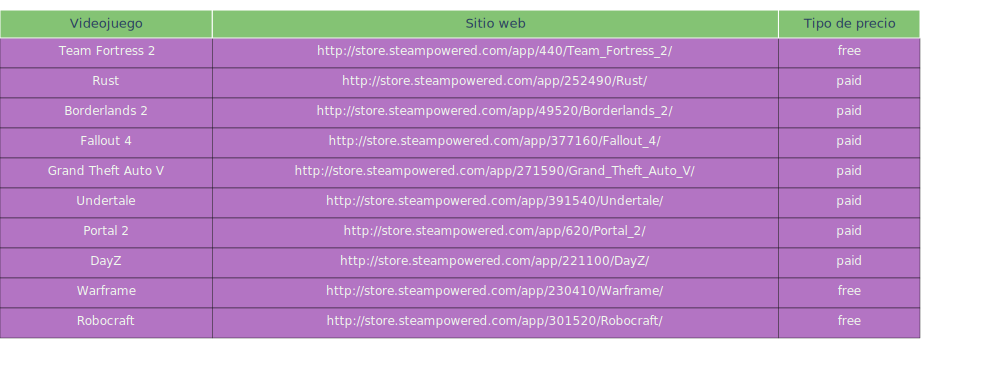

In [144]:
plot_table(reviews_games_amount.head(10))

#### Benchmark

In [145]:
def get_popularity_recommendations(username, top=10):
    df_recs = reviews_games_amount[~reviews_games_amount.id.isin(
        data_reviews.query('username==@username').product_id)]
    plot_table(df_recs.head(top))

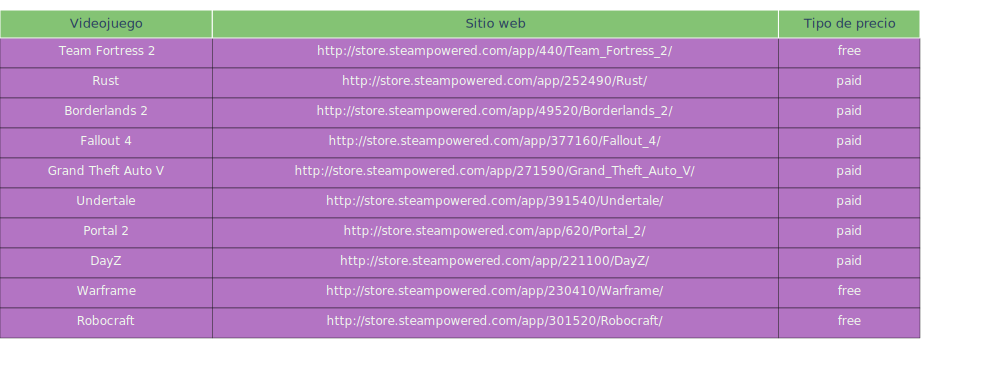

In [146]:
get_popularity_recommendations('backsea')

#### Filtro Colaborativo

##### Utilizaremos las Matrices de Factorización muy útiles para aproximar valoraciones implícitas
* Usaremos la librería implicit para mínimos cuadrados

In [147]:
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from implicit.evaluation import train_test_split
from scipy import sparse

In [148]:
# Merge data_reviews y data_games
reviews_games = pd.merge(data_reviews, data_games[['id', 'category_price']],
                        left_on='product_id',
                        right_on='id',
                        how='left')

In [149]:
reviews_games.head()

,username,hours,product_id,date,text,id,category_price
0,backsea,30.0,218230,2018-01-05,this game is good dont get me wrong i would li...,218230,free
1,RaZman,2.2,501300,2018-01-05,Beautifully narrated story about a peculiar fa...,501300,paid
2,Mike Dieu,1.5,367580,2018-01-05,"70 min to finish it, zen ambiance but still ch...",367580,paid
3,Sqeep The Screamin Frog,13.2,359550,2018-01-05,One of the best tactic games of all time . Tak...,359550,paid
4,lulatic13,6.7,327690,2018-01-05,"a very fun game, with nice character designs a...",327690,free


In [150]:
reviews_games.shape

(759235, 7)

In [151]:
# Convirtiendo a variable categórica
reviews_games['event'] = reviews_games['category_price'].astype(
    'category').cat.codes.astype(float)
reviews_games['user_code'] = reviews_games['username'].astype(
    'category').cat.codes

In [152]:
print(reviews_games.dtypes)

username                  object
hours                    float64
product_id                 int64
date              datetime64[ns]
text                      object
id                         int64
category_price            object
event                    float64
user_code                  int32
dtype: object


In [153]:
# Matriz de dispersión item-usuario y usuario-item
sparse_item_user = sparse.csr_matrix((reviews_games['hours'], (reviews_games['product_id'], reviews_games['user_code'])))
sparse_user_item = sparse.csr_matrix((reviews_games['hours'], (reviews_games['user_code'], reviews_games['product_id'])))

In [154]:
# Creando el modelo
model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=40)

In [155]:
alpha_val = 40
data_conf = (sparse_item_user * alpha_val).astype('double')

In [156]:
#  datos de entrenamiento y validación
train, test = train_test_split(data_conf, .7)

In [157]:
print('Shape:', train.getnnz(), test.getnnz())

Shape: 530942 228201


In [158]:
# Entrenar el modelo
model.fit(train)

#### Realizando las recomendaciones

In [159]:
#Usuario de prueba "backsea"
reviews_games.query('username=="backsea"').iloc[0]

username                                                    backsea
hours                                                            30
product_id                                                   218230
date                                            2018-01-05 00:00:00
text              this game is good dont get me wrong i would li...
id                                                           218230
category_price                                                 free
event                                                             0
user_code                                                    402468
Name: 0, dtype: object

In [160]:
user_id =  402468    #User_code backsea
recommended = model.recommend(user_id, sparse_user_item)
print(recommended)

[(221910, 0.648595), (242050, 0.6168986), (200710, 0.6112294), (215530, 0.5667082), (250760, 0.5248998), (207610, 0.50270736), (41500, 0.45422643), (249050, 0.4460891), (24740, 0.43829203), (261030, 0.434398)]


##### El resultado es el id del item y la calificacion implicita calculada por la librería

In [161]:
ids = [i[0] for i in recommended]
ids

[221910, 242050, 200710, 215530, 250760, 207610, 41500, 249050, 24740, 261030]

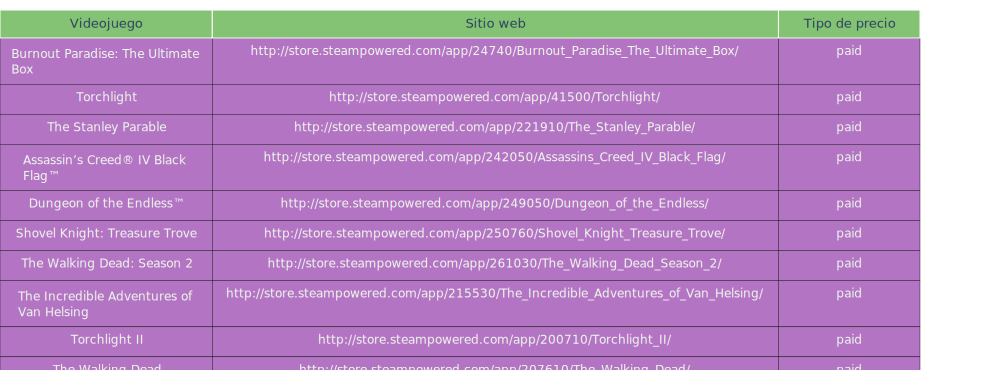

In [162]:
plot_table(data_games.query('id in @ids'))

#####  El resultado de la lista es diferente al Benchmark

In [163]:
# Items similares del usuario
reviews_games.query('user_code==@user_id').head(3)

,username,hours,product_id,date,text,id,category_price,event,user_code
0,backsea,30.0,218230,2018-01-05,this game is good dont get me wrong i would li...,218230,free,0.0,402468
127749,backsea,6.4,264240,2017-07-19,just appered in my steam library good game though,264240,paid,1.0,402468


[218230, 686200, 299800, 209000, 527810, 458700, 290730, 731920, 429790, 269710]


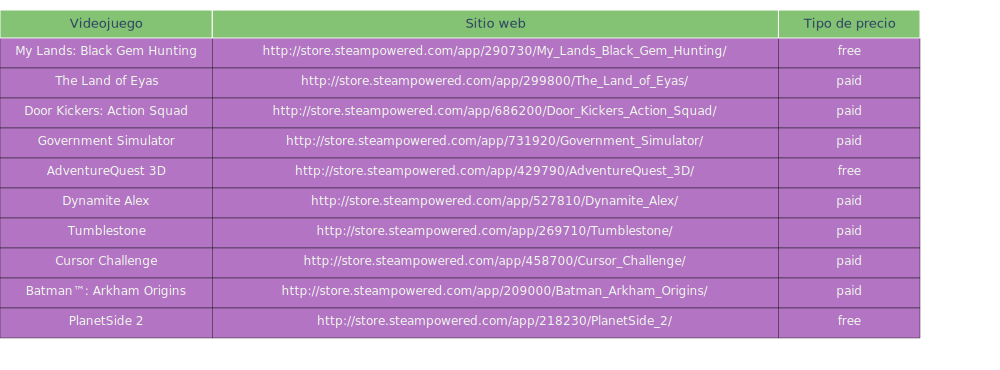

In [164]:
# Videojuegos similares columna id
item_id = 218230
ids = [i[0] for i in model.similar_items(item_id)]
print(ids)
plot_table(data_games.query('id in @ids'))

### -Parte C - Investigación

##### Realizaremos un análisis adicional usando matriz de factorización con LightFM

#### Matriz de Factorización con LightFM

###### LightFM una librería que utiliza los algoritmos de perdida WARP (Weighted Approximate-Rank Pairwise y BPR (Bayesian Personalised Ranking) con el fin de crear truplas (usuario, ítem positivo, ítem negativo) con el fin de estimar las preferencias desconocidas. Además hace posible combinar metadatos dentro de sistemas colaborativos.

In [165]:
# Instalar librería
# !pip install lightfm

In [166]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k
from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset

C:\Anaconda\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning:

LightFM was compiled without OpenMP support. Only a single thread will be used.



In [167]:
# Preparamos datos de validación y entrenamiento
data_reviews['user_code'] = data_reviews.username.astype('category').cat.codes

In [168]:
data_reviews.rename(columns={'user_code': 'user_id',
                             'product_id': 'item_id', 'hours': 'weight'}, inplace=True)

In [169]:
data_reviews.columns

Index(['username', 'weight', 'item_id', 'date', 'text', 'user_id'], dtype='object')

In [170]:
data_interactions = Dataset()
data_interactions.fit(
    users=data_reviews['user_id'], items=data_reviews['item_id'], )

In [171]:
interactions, weights = data_interactions.build_interactions(
    data_reviews[['user_id', 'item_id', 'weight']].values)

In [172]:
random_state_interactions = np.random.RandomState(seed=42)
train, test = random_train_test_split(
    interactions, test_percentage=.2, random_state=random_state_interactions)

In [173]:
random_state_weights = np.random.RandomState(seed=42)
train_weights, test_weights = random_train_test_split(
    interactions=weights, test_percentage=.2, random_state=random_state_weights)

In [174]:
print('Shapes:', train.getnnz(), test.getnnz())

Shapes: 607388 151847


In [175]:
# Crear modelo
lightFM = LightFM(loss='logistic')

In [176]:
# Entrenar el modelo
lightFM.fit(train, sample_weight=train_weights,
            verbose=True, epochs=30, num_threads=4)

Epoch: 100%|██████████| 30/30 [00:39<00:00,  1.33s/it]


In [177]:
# Evaluar el modelo
precision_at_k = precision_at_k(
    lightFM, test_interactions=test, train_interactions=train).mean()

print('Precision at k: %.7f' % precision_at_k)

Precision at k: 0.0001543


In [178]:
auc_score = auc_score(lightFM, test_interactions=test,
                      train_interactions=train).mean()


print('AUC Score: %.7f' % auc_score)

AUC Score: 0.7904246


In [179]:
# Generar las recomendaciones
def get_recommendations(model, interactions, user_id, n=10):
    n_users, n_items = interactions.shape
    all_scores = np.empty(shape=(0, n_items))
    
    # Adquiriendo calificaciones
    scores = model.predict(user_ids=user_id, item_ids=np.arange(n_items))
    all_scores = np.vstack((all_scores, scores))
    item_averages = np.mean(all_scores.astype(np.float), axis=0)
    
    # Asociando a items
    top_items_for_group = data_reviews.item_id.loc[np.argsort(-item_averages)][:n]
    return top_items_for_group

In [180]:
# Consultar recomendaciones para usuario de prueba
data_reviews.query('username=="backsea"').iloc[0]

username                                              backsea
weight                                                     30
item_id                                                218230
date                                      2018-01-05 00:00:00
text        this game is good dont get me wrong i would li...
user_id                                                402468
Name: 0, dtype: object

In [181]:
items_id = get_recommendations(lightFM, interactions, 402468)
items_id

2239    674940
6694    342310
1057    509000
7823    460920
6948    337000
4071    290930
2862      8930
1731       440
1102    210970
1643    466560
Name: item_id, dtype: int64

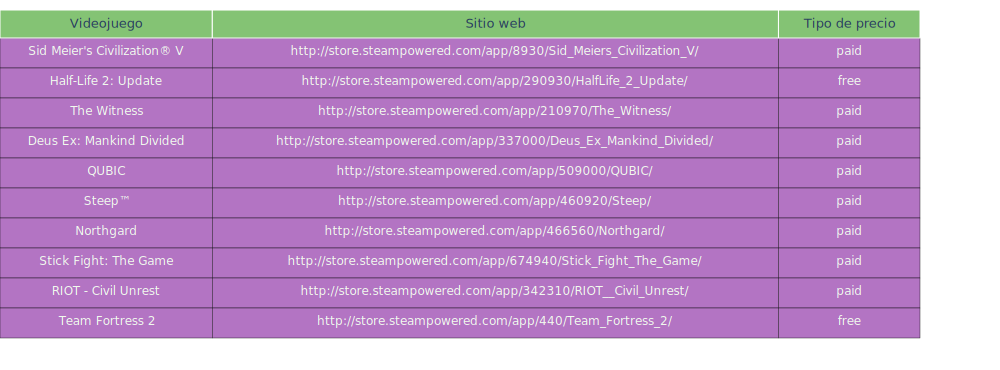

In [182]:
plot_table(data_games.query('id in @items_id'))

## Conclusiones

###### Un sistema de recomendación compara el perfil de usuarios con características de los ítems y predictivamente intenta identificar la calificación que este le daría. Estas características pueden ser dadas por el mismo ítem o inferidas implícitamente a través del contexto que dan otros usuarios.

###### Los datasets disponibles en este proyecto presentan grandes retos ya que están basados principalmente en comentarios de usuario y horas de uso sin una calificación directa sobre la experiencia del producto (ratings); adicionalmente se debe tener en cuenta que más del 80 % de los comentarios de los usuarios acerca de los productos están sobre los productos de pago de lo cuál se infiere que de la mayoría de los juegos gratuitos no están recibiendo registros (filtrados) suficientes ya que es bien conocido que los juegos gratuitos tienen mayores descargas en las diferentes plataformas.

###### Las librerías que implementan métricas de clasificación son las recomendadas en los sistemas de recomendación.

###### De los dos modelos utilizados seleccionamos el LigthFM con base a su AUC.

* ¿Cómo harías para ponerle un valor a la calificación?

###### Volvamos al dataset inicial ya que se creía que la columna `found_funny` por su nombre sería determinante, pero no hay consistencia y muchos valores faltantes de dicha columna, por lo tanto el planteamiento llevado a cabo con relación al mayor número de reviews y horas fue acertado cuando no hay una calificación directa del producto.


In [185]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

In [186]:
data_reviews = pd.DataFrame(data_reviews)

In [188]:
data_reviews.found_funny.value_counts()

1.0       70119
2.0       19612
3.0        8487
4.0        4859
5.0        2909
          ...  
1070.0        1
1075.0        1
270.0         1
1094.0        1
511.0         1
Name: found_funny, Length: 634, dtype: int64

In [192]:
valores = data_reviews[(data_reviews['found_funny']<=10)]

Valores totales:  779307
Valores faltantes:  659143


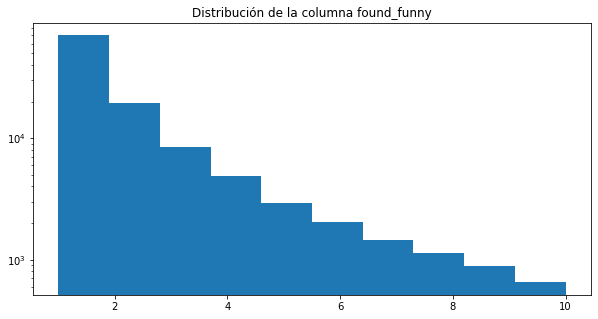

In [193]:
plt.figure(figsize=(10,5))
plt.hist(valores['found_funny'])
plt.yscale('log')
plt.title('Distribución de la columna found_funny')
plt.show

print('Valores totales: ',len(data_reviews))
print('Valores faltantes: ', data_reviews.found_funny.isna().sum() )

* ¿Hay algo que te gustaría investigar o probar?

##### Al igual que muchos otros sistemas de recomendación vigentes y muy conocidos como el de Netflix se establecerían la automatización de las encuestas a los usuarios sobre las sugerencias planteadas para validar (contrastar) en que porcentaje estuvo acertado el modelo.

### Artículos y referencias de interés consultados

https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe

https://implicit.readthedocs.io/en/latest/

https://medium.com/@jjlovesstudying/python-cuda-set-up-on-windows-10-for-gpu-support-78126284b085

https://towardsdatascience.com/how-to-build-a-movie-recommender-system-in-python-using-lightfm-8fa49d7cbe3b

https://towardsdatascience.com/solving-business-usecases-by-recommender-system-using-lightfm-4ba7b3ac8e62

https://www.kaggle.com/camiloemartinez/sistemas-de-recomendacion-con-surprise-y-lightfm

https://www.geeksforgeeks.org/running-python-script-on-gpu/

https://medium.com/@jonduke90/analyzing-steam-reviews-and-users-data-7a4ff3c5ce1a